In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
## Progress bar
from tqdm.notebook import tqdm

import json

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torch
import torchvision
#import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import json
import os
# Path to the folder where the pretrained models are saved
#CHECKPOINT_PATH = "/content/drive/MyDrive/Colab Notebooks/"

# Setting the seed
pl.seed_everything(42)
torch.manual_seed(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/tmp/ipykernel_109731/3257109053.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


In [2]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla V100S-PCIE-32GB


In [3]:
# Load the dataset
data_dir = 'UC_Merced_dataset/UCMerced_LandUse/Images'
dataset = datasets.ImageFolder(data_dir)

In [4]:
class UC_Merced(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

In [5]:
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Total number of classes: 21


In [6]:
# Mean and Std from ImageNet
labels = dataset.targets
input_size = 224
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # Convert PIL images to tensors
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# Load dataset and create data loader
dataset = datasets.ImageFolder(data_dir,transform=plain_transforms)
print("length of dataset: {}".format(len(dataset)))
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=8)

train_indices, val_indices = train_test_split(
    range(len(dataset)), test_size=0.2, stratify=labels
)

# Create subsets for training and validation sets
train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, val_indices)
#train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = data.DataLoader(train_set, batch_size=8, shuffle=True, drop_last=False, num_workers=8)
test_loader = data.DataLoader(test_set, batch_size=8, shuffle=True, drop_last=False, num_workers=4)
print("Train/test sizes: {}/{}".format(len(train_set), len(test_set)))
# Load label names to interpret the label numbers 0 to 999

label_names = class_names

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

length of dataset: 2100
Train/test sizes: 1680/420


Std model 

In [7]:
model_dir = 'UC_Merced_dataset/UCMerced_LandUse/models/models/'
model_file = model_dir + 'UC_Merced_std_model.pth'

# Make sure the directory exists (though it should already exist)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Load the same architecture (ResNet50)
model = models.resnet50(pretrained = False)

# Modify the final layer to match the number of classes (e.g., 21 for UC Merced)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)  # Assuming you have 21 classes

# Load the saved model state_dict
model.load_state_dict(torch.load(model_file))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode (for inference)
model.eval()

print('Model successfully loaded from {}'.format(model_file))

Model successfully loaded from UC_Merced_dataset/UCMerced_LandUse/models/models/UC_Merced_std_model.pth


In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
def eval_model(dataset_loader, img_func=None):
    tp, counter = 0., 0.
    all_preds = []
    all_labels = []

    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        if img_func is not None:
            imgs = img_func(imgs, labels)
        
        with torch.no_grad():
            preds = model(imgs)
        
        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.argmax(dim=-1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        tp += (preds.argmax(dim=-1) == labels).sum()
        counter += preds.shape[0]
    
    # Calculate accuracy
    acc = tp.float().item()/counter
    print(f"Top-1 accuracy: {(100.0 * acc):4.2f}%")
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc

Before Training

Validating...:   0%|          | 0/53 [00:00<?, ?it/s]

Top-1 accuracy: 4.29%


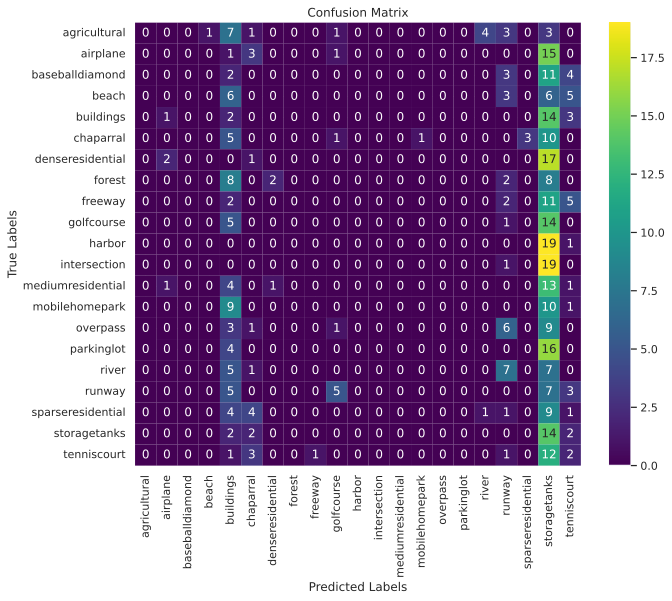

In [12]:
_ = eval_model(test_loader)

After Training

In [13]:
n_epochs = 5
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [14]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [15]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [16]:
# Keep track of the best loss and
# best model weights with the lowest loss
best_loss = np.inf
best_model = None

# Train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train_loader, criterion, optimizer)
  test_loss, _ = evaluate(model, test_loader, criterion)

  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

Epoch 1


  0%|          | 0/210 [00:00<?, ?it/s]

Train Loss: 2.80; Accuracy: 26.31


  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss: 2.37; Accuracy: 54.05
Epoch 2


  0%|          | 0/210 [00:00<?, ?it/s]

Train Loss: 2.23; Accuracy: 52.98


  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss: 1.79; Accuracy: 68.81
Epoch 3


  0%|          | 0/210 [00:00<?, ?it/s]

Train Loss: 1.76; Accuracy: 67.32


  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss: 1.34; Accuracy: 74.52
Epoch 4


  0%|          | 0/210 [00:00<?, ?it/s]

Train Loss: 1.39; Accuracy: 74.11


  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss: 1.01; Accuracy: 81.67
Epoch 5


  0%|          | 0/210 [00:00<?, ?it/s]

Train Loss: 1.16; Accuracy: 77.86


  0%|          | 0/53 [00:00<?, ?it/s]

Test Loss: 0.75; Accuracy: 82.62


Validating...:   0%|          | 0/53 [00:00<?, ?it/s]

Top-1 accuracy: 85.95%


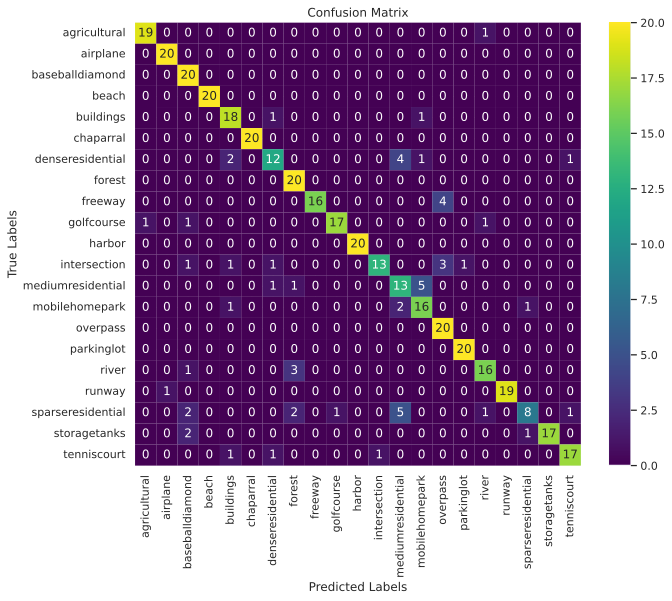

In [17]:
_ = eval_model(test_loader)

In [8]:

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

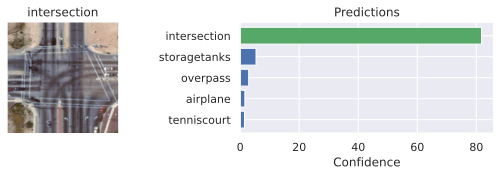

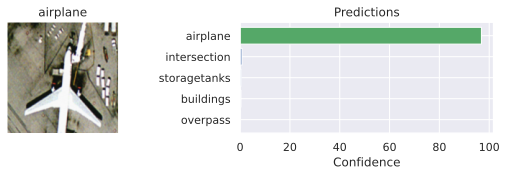

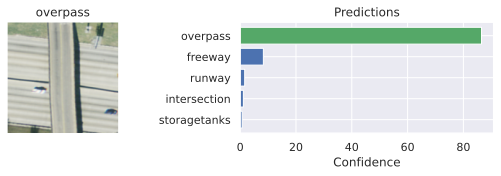

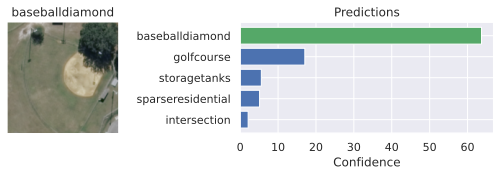

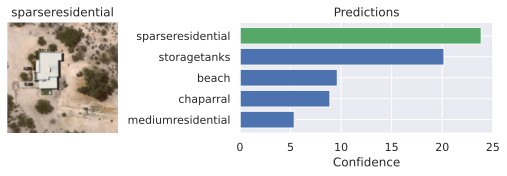

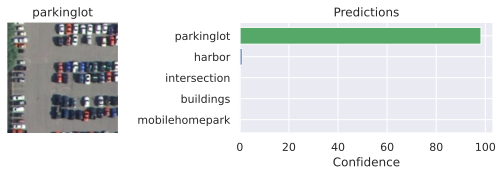

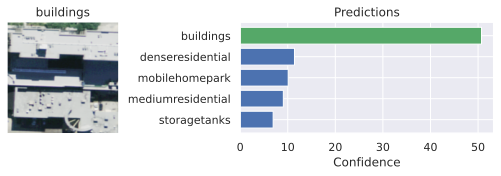

In [10]:
exmp_batch, label_batch = next(iter(test_loader))
with torch.no_grad():
    preds = model(exmp_batch.to(device))
num_examples = len(exmp_batch)
step = max(1, num_examples // 10)  # Adjust step to ensure diversity
for i in range(1,num_examples,step):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

FSGM Attack

In [14]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.1):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

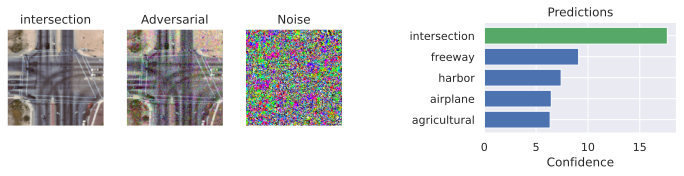

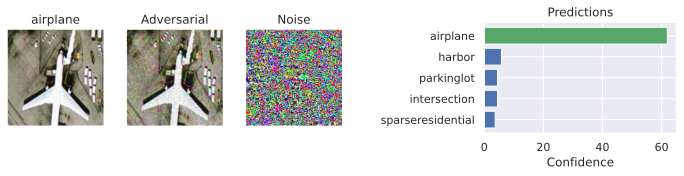

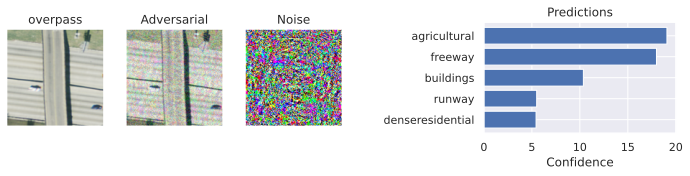

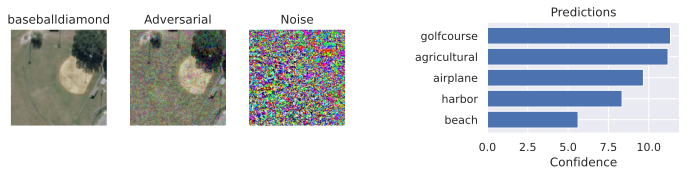

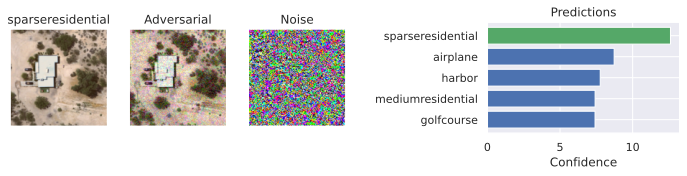

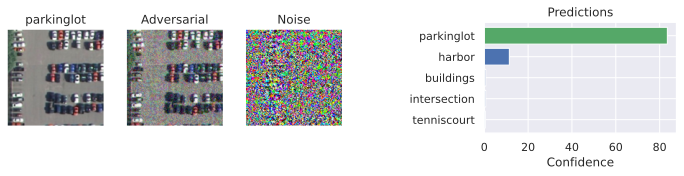

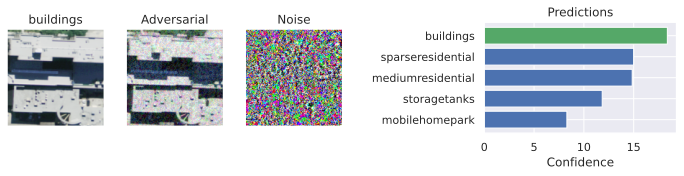

In [32]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.5)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))

for i in range(1,num_examples,step):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Validating...:   0%|          | 0/53 [00:00<?, ?it/s]

Top-1 accuracy: 35.00%


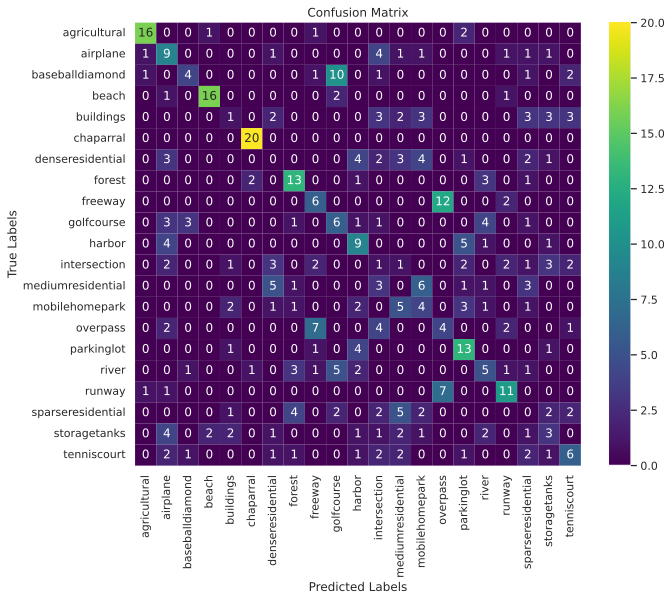

In [33]:
_ = eval_model(test_loader, img_func=lambda x, y: fast_gradient_sign_method(model, x, y, epsilon=0.08)[0]) #accuracu of whole dataset

In [34]:
def fgsm(model, X, y, epsilon=0.04):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.04, alpha=0.0005, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [35]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [36]:
opt = optim.SGD(model.parameters(), lr=1e-3)
best_loss = np.inf
best_model = None
for t in range(5):
    train_err, train_loss = epoch_adversarial(train_loader, model, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-4
    print(f"The train error is {train_err:.2f}", f"The test error is {test_err:.2f}", f"The adv error is {adv_err:.2f}", sep="\t")
    if adv_err < best_loss:
        best_loss = adv_err
        best_model= model.state_dict()
model_dir = 'EuroSAT_dataset/'  #UC_Merced_dataset/UCMerced_LandUse/models/modelsbest_model_UC_Merced_epoch_4.pth
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
model_file = model_dir + 'UCM_rob_mod_PGD.pth'
torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))



The train error is 0.52	The test error is 0.16	The adv error is 0.43
The train error is 0.33	The test error is 0.15	The adv error is 0.32
The train error is 0.26	The test error is 0.12	The adv error is 0.27
The train error is 0.21	The test error is 0.10	The adv error is 0.24
The train error is 0.18	The test error is 0.10	The adv error is 0.22
Model successfully saved to EuroSAT_dataset/UCM_rob_mod_PGD.pth


In [7]:
model_dir = 'EuroSAT_dataset/'
model_file = model_dir + 'UCM_rob_mod_PGD.pth'

# Make sure the directory exists (though it should already exist)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Load the same architecture (ResNet50)
model = models.resnet50(pretrained = False)

# Modify the final layer to match the number of classes (e.g., 21 for UC Merced)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)  # Assuming you have 21 classes

# Load the saved model state_dict
model.load_state_dict(torch.load(model_file))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode (for inference)
model.eval()

print('Model successfully loaded from {}'.format(model_file))

Model successfully loaded from EuroSAT_dataset/UCM_rob_mod_PGD.pth


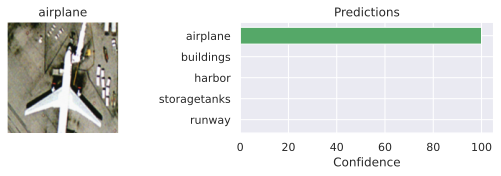

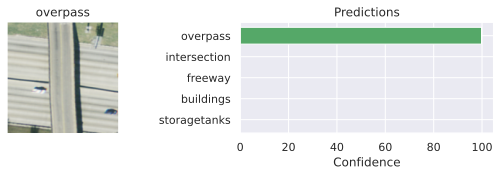

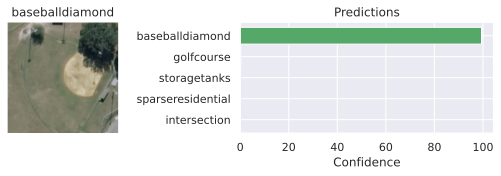

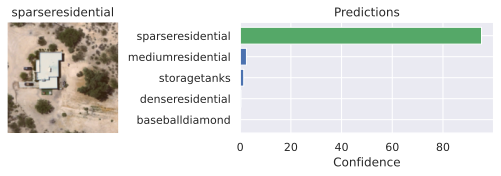

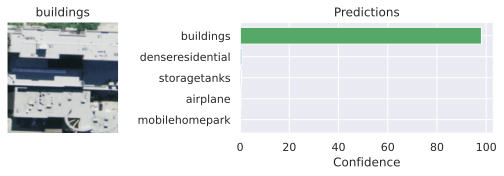

In [9]:
exmp_batch, label_batch = next(iter(test_loader))
with torch.no_grad():
    preds = model(exmp_batch.to(device))
num_examples = len(exmp_batch)
step = max(1, num_examples // 10)  # Adjust step to ensure diversity
for i in range(1,num_examples,step):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

Validating...:   0%|          | 0/53 [00:00<?, ?it/s]

Top-1 accuracy: 88.57%


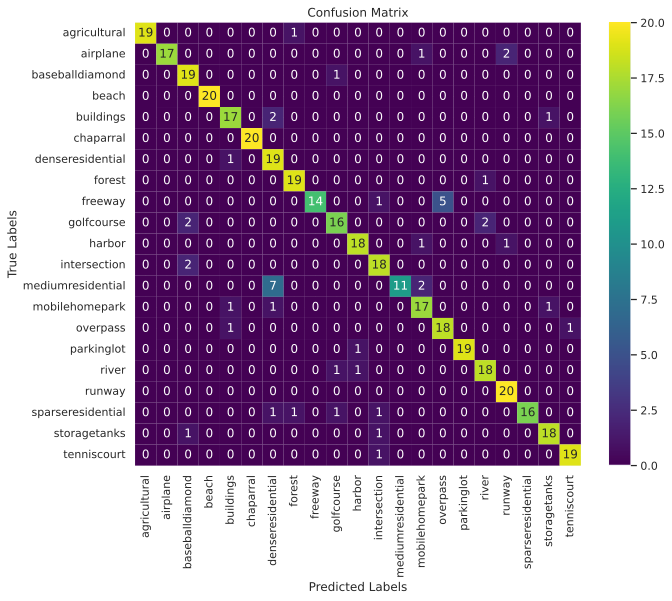

In [12]:
_ = eval_model(test_loader)

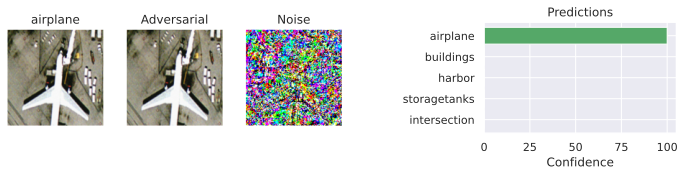

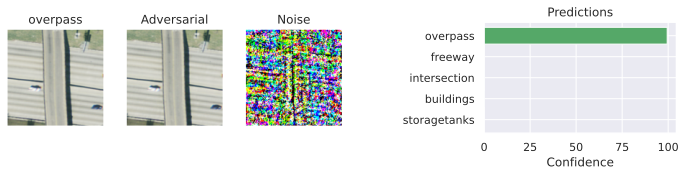

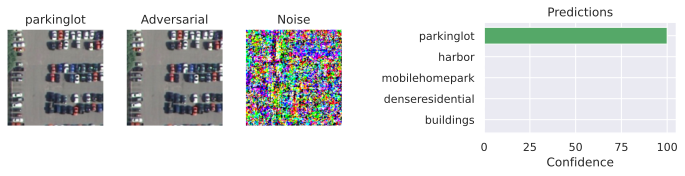

In [15]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.01)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))

for i in range(1,num_examples,step):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [23]:
_ = eval_model(test_loader, img_func=lambda x, y: fast_gradient_sign_method(model, x, y, epsilon=0.03)[0]) #accuracu of whole dataset

Validating...:   0%|          | 0/53 [00:00<?, ?it/s]

Top-1 accuracy: 61.67%
